In [1]:
import torch
import json
import random
import numpy as np
from embed_llm.models.augmented_model import EmbedAugPipeline
from embed_llm.generation.evaluation import  ensure_reproducibility
from bertviz import head_view, model_view # type: ignore
from embed_llm.models.mistral.generate import get_attention
from embed_llm.generation.metrics import (
    word_overlap,
    get_bleu_score,
    get_meteor,
    get_em,
    get_f1_score,
    metric_max_over_ground_truths,
    get_approx_em
)
import matplotlib.pyplot as plt
from embed_llm.generation.evaluation import (create_prompt, create_prompt_prefix)

/home/hippolytepilchen/micromamba/envs/llm_embed/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ensure_reproducibility(29)

In [3]:

#Must have a params json for pipeline
llm_path = '/lustre/scwpod02/client/kyutai-interns/hippop/models/mistral_7B'

# run_name = 'Hybrid_LLM_True_Emb_True_MaxEmb_1_PNoEmbed_0.01_StartPoint_0.0_16BS
# run_name = 'Hybrid_LLM_False_Emb_False_MaxEmb_1_PNoEmbed_0.0_StartPoint_0.8_16BS'
# run_name = 'Hybrid_LLM_False_Emb_True_MaxEmb_1_PNoEmbed_0.0_StartPoint_0.8_16BS'
run_name = 'ToyPretraining_LLM_False_Emb_True_MaxEmb_1_pure_reconstruct_16BS'
run_name = 'Hybrid_LLM_False_Emb_True_MaxEmb_1_PNoEmbed_0.0_StartPoint_0.5_16BS' # model pourri
last_ckpt = '030000' # '008500' #'010000' 



device = 'cuda' if torch.cuda.is_available() else 'cpu'

if torch.cuda.device_count() > 1:
    device = torch.device('cuda:0')
    print(f'Using {device} for loading')

w_embeds = True
max_batch_size = 4

instruct_ckpt = None #"/lustre/scwpod02/client/kyutai-interns/hippop/tmp/ToyDecompressingTests_LLM_FT_MaxEmb_1_reversed/checkpoints/checkpoint_005000"


Using cuda:0 for loading


In [4]:
pipeline: EmbedAugPipeline = EmbedAugPipeline.load_inference_model(
    llm_path=llm_path,
    ckpt_path="/lustre/scwpod02/client/kyutai-interns/hippop/tmp/"
    + run_name
    + "/checkpoints/checkpoint_"
    + last_ckpt,
    device=device,
    llm_name="Mistral7B",
    embed_model_name="NVEmbed",  # Not used if pretrainde ckpt available
    max_batch_size=max_batch_size,
    instruct_ckpt=instruct_ckpt,
)


Loading LoRA weights...
If n_layers is 1, hidden_dim must be equal to out_dim, 
 but hidden_dim is not equal to out_dim so hidden_dim is set to out_dim
Loading MLP projector


#### QA tests

In [5]:
eval_data = '/lustre/scwpod02/client/kyutai-interns/hippop/processed_data/eval_QA_NVEmbed/nq_open_data.jsonl' # nq_data.jsonl
context = []
questions = []
answers = []


with open(eval_data, "r") as f:
            for line in f:
                data = json.loads(line)
                questions.append(data["question"].strip())

                if isinstance(data["answer"], str):
                    answers.append([data["answer"].strip()])

                elif isinstance(data["answer"], list):
                    answers.append(data["answer"])
                else:
                    raise ValueError("Invalid answer type")
                # Take the first ranked retrieved passage
                context.append(data["passages"][0].strip())

c = list(zip(questions, context, answers))
fixed_random = random.Random(0.1)
fixed_random.shuffle(c)
questions, context, answers = zip(*c)
        

In [6]:
w_embeds = True
temp = 0
max_tokens = 64
icl_examples = 2
max_bs = 1
rag = False

device_count = torch.cuda.device_count()
other_device = device if device_count <= 1 else torch.device("cuda:1")

if w_embeds:
    pipeline.pipeline_args.w_embeds = True
else:
    pipeline.pipeline_args.w_embeds = False
    
prompt_prefix = create_prompt_prefix(
    queries=questions,
    answers=[answer[0] for answer in answers],
    docs=context if rag and not w_embeds else None,
    max_examples=icl_examples,
)

generated_sequences = []

queries = list(questions[icl_examples:])
docs = list(context[icl_examples:])
truths = list(answers[icl_examples:])
queries.reverse()
docs.reverse()
truths.reverse()

if w_embeds:

    no_context_prompt = [
        create_prompt(
            prefix=prompt_prefix, doc="", query=query, wdoc=False
        )
        for query in queries[:max_bs]
    ]

    context_prompt = [
        create_prompt(
            prefix=" answer the question following the examples:\n\n"
            + prompt_prefix,
            doc="",
            query=query,
            wdoc=False,
        )
        for query in queries[:max_bs]
    ]

else:


    no_context_prompt = [
        create_prompt(
            prefix=prompt_prefix,
            doc=doc if rag else '',
            query=query,
            wdoc=True,
        )
        for query, doc in zip(
            queries[:max_bs],
            docs[:max_bs],
        )
    ]


with open('/home/hippolytepilchen/code/embed_llm/results/gate_values/gate_values_1.jsonl', 'w') as f:
    f.write(json.dumps({'text_conditioning':docs[:max_bs], 'prompt':no_context_prompt, 'run_name':run_name})+'\n')

# for i, cont in enumerate(context_prompt if pipeline.pipeline_args.w_prefix_prompt else no_context_prompt):
#     print(f'{i}',cont)


print('Prompt Prefix:\n', prompt_prefix)
    # print(no_context_prompt[i] if not pipeline.pipeline_args.w_prefix_prompt else context_prompt[i])
    # print(f'Ground truth answer: {a}\n')
generated_sequence = pipeline.generate(
    prompt_pre_embed= (['']*len(queries[:max_bs]) if not pipeline.pipeline_args.w_prefix_prompt 
        else ['Based on the context ']*len(queries[:max_bs])),
    prompt_post_embed = context_prompt if pipeline.pipeline_args.w_prefix_prompt else no_context_prompt,
    text_conditioning= docs[:max_bs] if w_embeds else None,
    temperature=temp,
    max_tokens=max_tokens,
    truncate_line=False,
    device=device,
    device_generation=other_device,
)

print('GENERATION')
for i, (q, a, d, g) in enumerate(zip(queries[:max_bs], truths[:max_bs], docs[:max_bs], generated_sequence)):
    print(f'Given Query: {q}\nGT Answer: {a}\nContext Given {d}[...]\nAnswer in context? {get_approx_em(d,a[0])}','\nPrediction:', g, '\n\n')



Prompt Prefix:
 Query: who is the current director of the us mint
Answer: David J. Ryder

Query: who is the leader of the ontario pc party
Answer: Patrick Brown




/home/hippolytepilchen/code/embed_llm/embed_llm/models/mistral/cross_att_transformer.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val, repeats=torch.tensor(seqlen).to(val.device), dim=1


GENERATION
Given Query: who won season 5 of hell's kitchen
GT Answer: ['Executive Chef Danny Veltri', 'Danny Veltri']
Context Given Season 5 of the American competitive reality television series Hell's Kitchen began airing on the Fox Network starting on January 29, 2009. The season concluded on May 14, 2009. Gordon Ramsay returned as head chef, as well as sous chefs Scott Leibfried and Gloria Felix and maître d' Jean-Philippe Susilovic. Executive Chef Danny Veltri won the series and was awarded a sous chef position under Stephen Kalt at Italian restaurant Fornelletto at the Borgata in Atlantic City, New Jersey. Danny also received $250,000 in prize money from the show. This season also set a high number of unusual eliminations; with one chef eliminated without nomination, two chefs leaving due to medical issues, and two chefs eliminated during service, in addition to the first time a chef was eliminated despite being on the winning team, which would become more prominent in later seaso

In [11]:

stats_per_layer = {}
current_layer = 0

with open('/home/hippolytepilchen/code/embed_llm/results/gate_values/gate_values_1.jsonl', 'r') as f:
    for line in f:

        sample = json.loads(line)
       
        if 'run_name' in sample.keys():
            continue
        
        if 'layer' in sample.keys():
            if sample['layer'] not in stats_per_layer.keys():
                stats_per_layer[sample['layer']] = []
            current_layer = sample['layer']
        else:
            stats_per_layer[current_layer].append(sample)
            
            
        
            

{'text_conditioning': ["Season 5 of the American competitive reality television series Hell's Kitchen began airing on the Fox Network starting on January 29, 2009. The season concluded on May 14, 2009. Gordon Ramsay returned as head chef, as well as sous chefs Scott Leibfried and Gloria Felix and maître d' Jean-Philippe Susilovic. Executive Chef Danny Veltri won the series and was awarded a sous chef position under Stephen Kalt at Italian restaurant Fornelletto at the Borgata in Atlantic City, New Jersey. Danny also received $250,000 in prize money from the show. This season also set a high number of unusual eliminations; with one chef eliminated without nomination, two chefs leaving due to medical issues, and two chefs eliminated during service, in addition to the first time a chef was eliminated despite being on the winning team, which would become more prominent in later seasons."], 'prompt': ["Query: who is the current director of the us mint\nAnswer: David J. Ryder\n\nQuery: who i

KeyError: 0

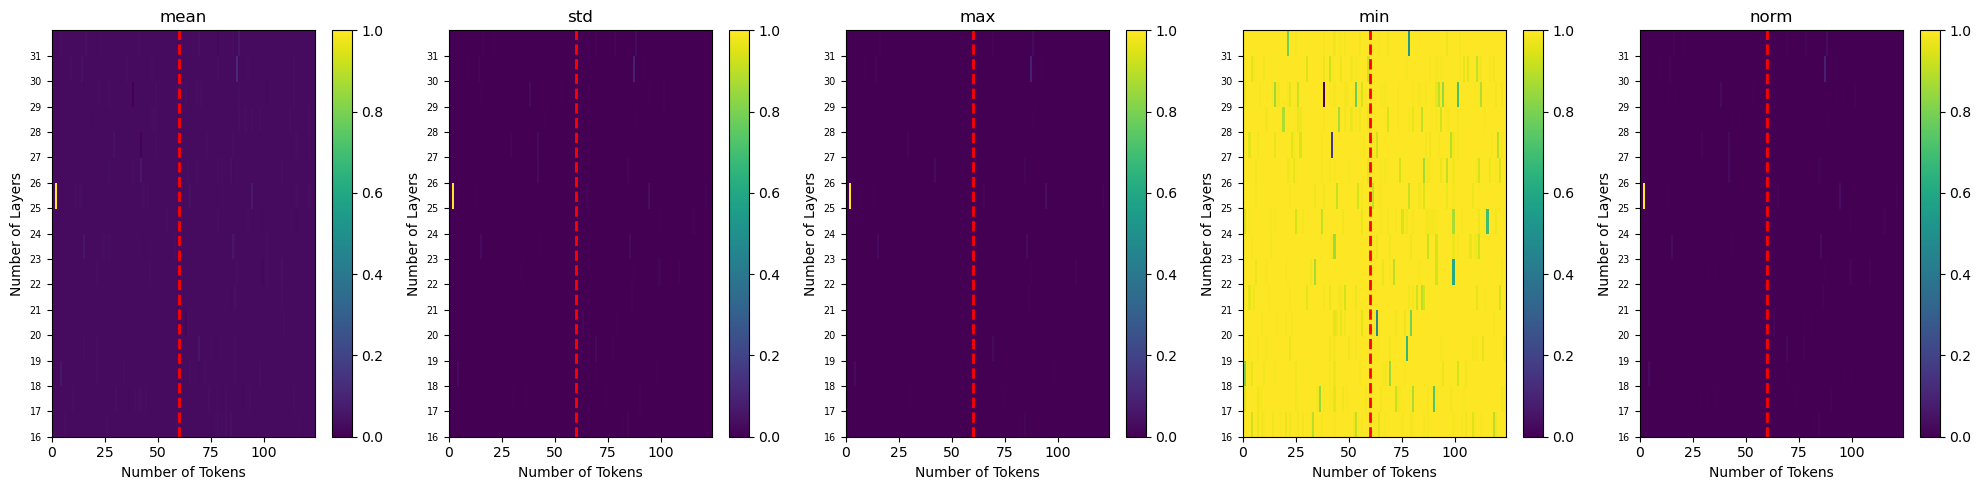

In [ ]:
metrics = ["mean", "std", "max", "min", "norm"]

f, ax = plt.subplots(1, 5, figsize=(20, 5))
n_layers, n_tokens = np.meshgrid(list(stats_per_layer.keys()), range(len(stats_per_layer['16'])))

for i, measure in enumerate(metrics):
    
    value = [0]*len(stats_per_layer)
    for j, layer in enumerate(stats_per_layer.values()):
        value[j] = []
        for stats in layer:
            if len(stats['relative_gap'][measure]) == 1:
                value[j].append(stats['relative_gap'][measure][0])
            else:
                value[j].extend(stats['relative_gap'][measure])
    
    value = np.array(value)
    # Normalize values
    value = (value - value.min()) / (value.max() - value.min())
    # Create heatmap
    c =ax[i].pcolor(value, shading='auto', cmap='viridis')
    f.colorbar(c, ax=ax[i])
    # Set labels and title
    ax[i].set_title(measure)
    ax[i].set_yticks(range(16),list([int(key) for key in stats_per_layer.keys()]),size = 'x-small')
    ax[i].set_xlabel('Number of Tokens')
    ax[i].set_ylabel('Number of Layers')
    ax[i].axvline(x=value.shape[1]-max_tokens, color='red', linestyle='--', linewidth=2)
f.tight_layout()

plt.show()



#### Reconstruct tests

In [ ]:
w_embeds = True
temp = 0.7
max_tokens = 256
n_context = 0
i_token_to_flip = -1

device_count = torch.cuda.device_count()
other_device = device if device_count <= 1 else torch.device("cuda:1")

if w_embeds:
    pipeline.pipeline_args.w_embeds = True
else:
    pipeline.pipeline_args.w_embeds = False

temp = [temp] * max_tokens   
if max_tokens > i_token_to_flip >= 0:
    temp[i_token_to_flip] = -1

# 1 information in the doc which enables to answer the question but not good response often in-context
# 2 information in the doc which enables to answer the question and good response often in-context
# 3 Hard negative passage



prompt_prefix = ["Query: who wrote the song photograph by ringo starr\nAnswer: Ringo Starr\n\n","Query: who is playing the halftime show at super bowl 2016\nAnswer: Coldplay\n\n","Query: where was the world economic forum held this year\nAnswer: Davos\n\n","Query: where are the giant redwoods located in california\nAnswer: Humboldt County\n\n","Query: who has made the most premier league appearances\nAnswer: Gareth Barry\n\n"]
prompt_prefix = ''.join(prompt_prefix[:n_context])
# prompt_prefix = "Query: "

# prompts = ['who has most followers on instagram in world','who did the united states win its independence from', 'what is the capital of France']
prompts = ["what is the hot coffee mod in san andreas","who wrote he ain't heavy he's my brother lyrics","when was the last time anyone was on the moon"]
context_prompts = [' answer the question following the examples ' +prompt_prefix + 'Query: '+ prompt  + '\nAnswer:' for prompt in prompts]
no_context_prompts = [prompt_prefix + 'Query: '+ prompt + '\nAnswer:' for prompt in prompts]

# conditioning = ["This list contains the top 50 accounts with the most followers on the photo and video-sharing social platform Instagram. As of July 2019, the most followed user is Instagram's own account, with over 308 million followers. Cristiano Ronaldo is the most followed individual, with over 177 million followers. Fifteen accounts have exceeded 100 million followers on the site.",
#                 "During the American Revolution, the legal separation of the thirteen colonies from Great Britain in 1776 actually occurred on July 2, when the Second Continental Congress voted to approve a resolution of independence that had been proposed in June by Richard Henry Lee of Virginia declaring the United States independent from Great Britain's rule. After voting for independence, Congress turned its attention to the Declaration of Independence, a statement explaining this decision, which had been prepared by a Committee of Five, with Thomas Jefferson as its principal author. Congress debated and revised the wording of the Declaration, finally approving it two days later on July 4. A day earlier, John Adams had written to his wife Abigail",
#                 "France is a country located primarily in Western Europe. Its overseas regions and territories include French Guiana in South America, Saint Pierre and Miquelon in the North Atlantic, the French West Indies, and many islands in Oceania and the Indian Ocean, giving it one of the largest discontiguous exclusive economic zones in the world. Metropolitan France shares borders with Belgium and Luxembourg to the north, Germany to the northeast, Switzerland to the east, Italy and Monaco to the southeast, Andorra and Spain to the south, and a maritime border with the United Kingdom to the northwest. Its metropolitan area extends from the Rhine to the Atlantic Ocean and from the Mediterranean Sea to the English Channel and the North Sea. "]

conditioning = ['Hot Coffee is a normally inaccessible mini-game in Grand Theft Auto: San Andreas. The mini-game portrays crudely animated sexual intercourse between the main character and a chosen partner. After Patrick Wildenborg, a software engineer who also went by the alias \"PatrickW\", modified the game to make the mini-game accessible, Hot Coffee quickly gained notoriety worldwide, impacting consumer culture, politics and the video game industry as a whole. Rockstar initially blamed a \"determined group of hackers\" for hacking the base game and creating the mini-game from scratch. This claim was eventually refuted, as the mini-game\'s code and assets had been developed by Rockstar and were already present, unfinished and abandoned, on the game disc: the mod simply made the existing content available to players. Rockstar would go on to indicate that they expected the ESRB rating to remain unchanged, as they had no control',
                "He Ain't Heavy, He's My Brother written by Bob Russell and Bobby Scott; all other titles written by Neil Diamond.",
                "17, 1970, as part of the Lunokhod program. To date, the last human to stand on the Moon was Eugene Cernan, who as part of the Apollo 17 mission, walked on the Moon in December 1972. Apollo 17 was followed by several uncrewed interplanetary missions operated by NASA. One of the notable interplanetary missions is Voyager 1, the first artificial object to leave our Solar System into interstellar space on August 25, 2012. It is also the most distant artificial object from Earth. The probe passed the heliopause at 121 AU to enter interstellar space. Voyager 1 is currently at a distance of 145.11 AU (21.708 billion kilometers; 13.489 billion miles) from Earth as of January 1, 2019."]

# answers = ['Instagram','Great Britain',"Paris"]
# answers = ["a normally inaccessible mini-game", ["Bobby Scott", "Bob Russell"],["14 December 1972 UTC", "December 1972"]]

# conditioning = 'Kyutai is a non-profit laboratory dedicated to open research in AI, founded in November 2023 by the iliad Group, CMA CGM and Schmidt Sciences.'
# prompts =  prompt_prefix +'Query: when was founded Kyutai?\nAnswer: '



if w_embeds:
    pipeline.pipeline_args.w_embeds = True
else:
    pipeline.pipeline_args.w_embeds = False

generated_sequence = pipeline.generate(
    prompt_pre_embed = (['']*len(conditioning) if not pipeline.pipeline_args.w_prefix_prompt 
    else ['Based on the context ']*len(conditioning)), 
    prompt_post_embed = context_prompts if pipeline.pipeline_args.w_prefix_prompt  else no_context_prompts,
    text_conditioning=conditioning,
    temperature=temp,
    max_tokens=max_tokens,
    truncate_double_space=True,
    device=device,
    device_generation=other_device,
)

for seq in generated_sequence:
    print(seq)



In [5]:
lim_toks = pipeline.pipeline_args.max_seq_len

atlas_eval_data = "/lustre/scwpod02/client/kyutai-interns/hippop/processed_data/wiki_passages_pretraining/valid_atlas_enwiki-dec2021_standard.jsonl"
atlas_valid_passage = []
dump_eval_data = '/lustre/scwpod02/client/kyutai-interns/datasets/modular_finetuning/enwiki-20220120_valid.jsonl'
dump_valid_passage = []

with open(atlas_eval_data, "r") as f:
    for i, line in enumerate(f):
        atlas_valid_passage.append(
            pipeline.tokenizer.decode(
                pipeline.tokenizer.encode(
                    json.loads(line)["text"], eos=True, bos=True
                )[:lim_toks]
            )
            )
random.shuffle(atlas_valid_passage)


with open(dump_eval_data, "r") as f:
    for i, line in enumerate(f):
        text = json.loads(line)["text"]
        dump_valid_passage.append(
                pipeline.tokenizer.decode(
                    pipeline.tokenizer.encode(
                        text if "\n\n" not in   text else text.split("\n\n")[1], eos=True, bos=True
                    )[:lim_toks]
                )
            )
random.shuffle(dump_valid_passage)



In [7]:
n_passages = 100

In [8]:
temp = 0.0
device_count = torch.cuda.device_count()
other_device = device if device_count <= 1 else torch.device("cuda:1")
atlas_generated_sequences = []
for i in range(0, n_passages, max_batch_size):
    passage = atlas_valid_passage[i : i + max_batch_size]
    generated_sequence, logprobs = pipeline.generate(
        prompt_pre_embed = (['']*len(passage) if not pipeline.pipeline_args.w_prefix_prompt 
        else ['In other words, background: ']*len(passage)), 
        prompt_post_embed = (['']*len(passage) if not pipeline.pipeline_args.w_prefix_prompt 
        else [' is just another way of saying: ']*len(passage)),
        text_conditioning=passage,
        temperature=temp,
        max_tokens=lim_toks,
        truncate_double_space=False,
        device=device,
        device_generation=other_device,
    )

    atlas_generated_sequences.extend(generated_sequence)

In [9]:
temp = 0.0
device_count = torch.cuda.device_count()
other_device = device if device_count <= 1 else torch.device("cuda:1")
dump_generated_sequences = []
for i in range(0, n_passages, max_batch_size):
    passage = dump_valid_passage[i : i + max_batch_size]
    generated_sequence, logprobs = pipeline.generate(
        prompt_pre_embed = (['']*len(passage) if not pipeline.pipeline_args.w_prefix_prompt 
        else ['In other words, background: ']*len(passage)), 
        prompt_post_embed = (['']*len(passage) if not pipeline.pipeline_args.w_prefix_prompt 
        else [' is just another way of saying: ']*len(passage)),
        text_conditioning=passage,
        temperature=temp,
        max_tokens=lim_toks,
        truncate_double_space=False,
        device=device,
        device_generation=other_device,
    )

    dump_generated_sequences.extend(generated_sequence)

In [ ]:
avg_bleu = 0
n_mismatch = 0
n_very_small_blue = 0
for gen, gt in zip(dump_generated_sequences, dump_valid_passage):
    bleu_score = get_bleu_score(gt, gen)
    avg_bleu += bleu_score
    
    try:
        if bleu_score != get_bleu_score(gt, gen, trunc = True):
            n_mismatch += 1
            # print('MISMATCH {}'.format(n_mismatch))
            # print('Ge:', gen)
            # print('GT:', gt)
            # print(bleu_score, ' | ', get_bleu_score(gt, gen, trunc = True))
            if bleu_score < 0.1:
                n_very_small_blue += 1
            
        elif bleu_score < 0.1:
            n_very_small_blue += 1
            print('VERY SMALL BLEU {}'.format(n_very_small_blue))
            print('Ge:', gen)
            print('GT:', gt)
            print(bleu_score)
    except ValueError:
        print('Passages skipped')

print('AVG scores',get_bleu_score(dump_valid_passage, dump_generated_sequences))
print('AVG scores TRUNC',get_bleu_score(dump_valid_passage, dump_generated_sequences, trunc = True))
print('Very small bleu', n_very_small_blue)
print('Mismatch', n_mismatch)

AVG scores 0.8125772827951994
AVG scores TRUNC 0.8183385157580503
Very small bleu 1
Mismatch 31


In [ ]:
avg_bleu = 0
n_mismatch = 0
n_very_small_blue = 0
for gen, gt in zip(atlas_generated_sequences, atlas_valid_passage):
    try:
        bleu_score = get_bleu_score(gt, gen)
        avg_bleu += bleu_score
    except ValueError:
        print('Passages skipped')
    
    try:
        if bleu_score != get_bleu_score(gt, gen, trunc = True):
            n_mismatch += 1
            # print('MISMATCH {}'.format(n_mismatch))
            # print('Ge:', gen)
            # print('GT:', gt)
            # print(bleu_score, ' | ', get_bleu_score(gt, gen, trunc = True))
            if bleu_score < 0.1:
                n_very_small_blue += 1
            
        elif bleu_score < 0.1:
            n_very_small_blue += 1
            print('VERY SMALL BLEU {}'.format(n_very_small_blue))
            print('Ge:', gen)
            print('GT:', gt)
            print(bleu_score)
    except ValueError:
        print('Passages skipped')

print('AVG scores',get_bleu_score(atlas_valid_passage, atlas_generated_sequences))
print('AVG scores TRUNC',get_bleu_score(atlas_valid_passage, atlas_generated_sequences, trunc = True))
print('Very small bleu', n_very_small_blue)
print('Mismatch', n_mismatch)

VERY SMALL BLEU 1
Ge: 0 A subsequence of a string whose characters are common in two strings (S1 and S2) can be computed efficiently using the notion of common subsequence. The problem has a simple algorithmic solution; both standard algorithms run in linear time in DSPSS (this is still faster than in Python) for a computer. It has been well studied in mathematics, its basic notions of deletions and appearances, the problem of finding Maximal Common Subsequences for sequences of four or more characters, for extra characters with few constraints that have the property of overlapping in more than one way. This problem (and its generalization to image alignment and image reconstruction) fits in studies of the geometry of editing theories (in Russian), dynamical systems, and computer science, and is motivated by the mean comparison of DNA sequences and the reconstruction of common subsequences at short edit distances. If one computes long subsequences of S1 and S2, such that the computatio

### Other tests

In [5]:
# Flipping attempts
w_embeds = True
temp = 0
max_tokens = 128
i_token_to_flip = -1
if w_embeds:
    pipeline.pipeline_args.w_embeds = True
else:
    pipeline.pipeline_args.w_embeds = False

temp = [temp] * max_tokens   
if max_tokens > i_token_to_flip >= 0:
    temp[i_token_to_flip] = 1000
    
prompt = ''
text_conditioning ='Mario Bortolazzi (born 10 January 1965, in Verona) is an Italian professional football coach and a former player, who played as a midfielder. \
    \n\nHe played 12 seasons (241 games, 14 goals) in the Serie A for ACF Fiorentina, A.C. Milan, Hellas Verona F.C., Atalanta B.C. and Genoa C.F.C.'
        # \n\nIn his coaching career he has so far has always been an assistant to his former Milan teammate Roberto Donadoni.\
        #     \n\nHonours\n\n - Milan\n - Serie A champion: 1987–88.\n\n - Genoa\n - Anglo-Italian Cup winner: 1995–96.'



            
generated_sequence, attn_or_logprobs, embeddings = pipeline.generate(prompt_pre_embed = ['In other words, background: ',''], 
                                    prompt_post_embed = [' is just another way of saying: ',''],
                                    text_conditioning = [text_conditioning]*2, 
                                    temperature = temp, 
                                    max_tokens = max_tokens,
                                    truncate_double_space = False,
                                    random_flip = i_token_to_flip,
                                    device = device,
                                    device_generation = device if torch.cuda.device_count() <= 1 else torch.device('cuda:1'),
                                    return_embeddings = True)
print(generated_sequence)

/home/hippolytepilchen/.cache/huggingface/modules/transformers_modules/nvidia/NV-Embed-v2/5130cf1daf847c1bacee854a6ef1ca939e747fb2/modeling_nvembed.py:349: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(batch_dict.get('input_ids').to(batch_dict.get('input_ids')).long()),


Prompt Pre Embed: [8, 0]
Prompt Post Embed: [10, 1]
['\n\nMario Alberto Bortolazzi (born 12 January 1964) is a former professional footballer who played as a midfielder. He played for 12 seasons at A.C. Milan, winning the Serie A championship in 1991–92, and the Coppa Italia in 1993–94. He was transferred to Genoa C.F.C. for 500,000 lire, and made his debut on 25 September 1995, in a match against Fiorentina at', 'Mario Bortolazzi\n\nMario Bortolazzi (born 12 January 1965 in Genoa) is an Italian former professional football player and coach. He played 12 seasons in Serie A, for A.C. Milan, Atalanta, Fiorentina, and Hellas Verona. He played 246 games in Serie A, scoring 14 goals. 1990–91 season, he played 12 games in Serie B, for A.C. Milan. 1991–92 season,']


In [6]:
n_passages = 20

lim_toks = 128
eval_data = '/lustre/scwpod02/client/kyutai-interns/datasets/modular_finetuning/enwiki-20220120_valid.jsonl'
train_data = '/lustre/scwpod02/client/kyutai-interns/datasets/modular_finetuning/enwiki-20220120_train.jsonl'
train_passage = []
valid_passage = []

with open(train_data, 'r') as f:
    for i, line in enumerate(f):
        if i == n_passages:
            break
        train_passage.append(pipeline.tokenizer.decode(pipeline.tokenizer.encode(json.loads(line)['text'].split('\n\n')[1], eos = True, bos = True)[:lim_toks]))
  
with open(eval_data, 'r') as f:
    for i, line in enumerate(f):
        if i == n_passages:
            break
        valid_passage.append(pipeline.tokenizer.decode(pipeline.tokenizer.encode(json.loads(line)['text'].split('\n\n')[1], eos = True, bos = True)[:lim_toks]))
        

In [41]:
w_embeds = True
temp = 0
max_tokens = 128
i_token_to_flip = -1
if w_embeds:
    pipeline.pipeline_args.w_embeds = True
else:
    pipeline.pipeline_args.w_embeds = False

temp = [temp] * max_tokens   
if max_tokens > i_token_to_flip >= 0:
    temp[i_token_to_flip] = 1000

# prompt_prefix = "Query: who wrote the song photograph by ringo starr\nAnswer: Ringo Starr\n\nQuery: who is playing the halftime show at super bowl 2016\nAnswer: Coldplay\n\nQuery: where was the world economic forum held this year\nAnswer: Davos\n\nQuery: where are the giant redwoods located in california\nAnswer: Humboldt County\n\nQuery: who has made the most premier league appearances\nAnswer: Gareth Barry\n\nQuery: "
prompt_prefix = "Query: "
prompts = ['who has most followers on instagram in world','who did the united states win its independence from', 'locations for the film an englishman who went up a hill', 'who is the valley of the dolls based on']
prompts = [prompt_prefix + prompt + '\nAnswer:' for prompt in prompts]

conditioning = ["This list contains the top 50 accounts with the most followers on the photo and video-sharing social platform Instagram. As of July 2019, the most followed user is Instagram's own account, with over 308 million followers. Cristiano Ronaldo is the most followed individual, with over 177 million followers. Fifteen accounts have exceeded 100 million followers on the site.",
                     "During the American Revolution, the legal separation of the thirteen colonies from Great Britain in 1776 actually occurred on July 2, when the Second Continental Congress voted to approve a resolution of independence that had been proposed in June by Richard Henry Lee of Virginia declaring the United States independent from Great Britain's rule. After voting for independence, Congress turned its attention to the Declaration of Independence, a statement explaining this decision, which had been prepared by a Committee of Five, with Thomas Jefferson as its principal author. Congress debated and revised the wording of the Declaration, finally approving it two days later on July 4. A day earlier, John Adams had written to his wife Abigail",
                     'The village was a primary location for the making of the film \"The Englishman Who Went Up a Hill But Came Down a Mountain\", which starred Hugh Grant. The hilltop scenes were filmed on the Gyrn, the long hill that overlooks the village. It was also featured in \"Monk\'s Hood\", an episode of \"The Cadfael Chronicles\"',
                     'Valley of the Dolls is the first novel by American writer Jacqueline Susann. Published in 1966, the book was the biggest selling novel of its year. To date, it has sold more than 31 million copies, making it one of the best-selling works in publishing history.']

# answers = ['Instagram','Great Britain',"Llansilin in Powys",["Judy Garland", "Carole Landis", "Dean Martin", "Ethel Merman"]]

# conditioning = 'Kyutai is a non-profit laboratory dedicated to open research in AI, founded in November 2023 by the iliad Group, CMA CGM and Schmidt Sciences.'
# prompts =  prompt_prefix +'Query: when was founded Kyutai?\nAnswer: '



if w_embeds:
    pipeline.pipeline_args.w_embeds = True
else:
    pipeline.pipeline_args.w_embeds = False
pipeline.model.llm.pos_to_keep = []
generated_sequence, logprobs = pipeline.generate(prompts = prompts, 
                                    text_conditioning = conditioning, 
                                    temperature = temp, 
                                    max_tokens = max_tokens,
                                    truncate_double_space = False,
                                    random_flip = i_token_to_flip,
                                    device = device,
                                    device_generation = device if torch.cuda.device_count() <= 1 else torch.device('cuda:1'),
                                    return_embeddings = False)
print(generated_sequence)


## Vizualisation

In [ ]:
self_att_weights, tokens = get_attention(generated_sequence[0], embeddings, pipeline.tokenizer, pipeline.model.llm, n_tokens = 20)
# self_att_weights, tokens = get_attention('He played 12 seasons (243 games, 14 goals) in the Serie A for A.C. Milan, A.F.C. Fiorentina, Hellas Verona, Atalanta B.C. and Genoa C.F.C.', embeddings, pipeline.tokenizer, pipeline.model.llm, n_tokens = 20)

head_view(self_att_weights, tokens)

In [ ]:
self_att_weights, tokens = get_attention(generated_sequence[0], embeddings, pipeline.tokenizer, pipeline.model.llm, n_tokens = 20)
model_view([att[:,:,1:,1:] for att in self_att_weights], [tokens[0]] + tokens[2:])

In [ ]:

mean_per_head_att = [torch.mean(att, dim = 1, keepdim = True) for att in self_att_weights]
overall_mean = torch.mean(torch.stack(self_att_weights), dim = 0)

head_view(mean_per_head_att, tokens)
# head_view([overall_mean], tokens)

## Evaluation metrics

In [ ]:
print(stop)
temperatures = [0, 0.5, 0.7, 1, 1.5]
max_tokens = 150

results_generation = {'0':{'train': {'word_prompt':{}, 'empty_prompt':{}}, 'valid': {'word_prompt':{}, 'empty_prompt':{}}}, 
                        '0.5':{'train': {'word_prompt':{}, 'empty_prompt':{}}, 'valid': {'word_prompt':{}, 'empty_prompt':{}}},
                        '0.7':{'train': {'word_prompt':{}, 'empty_prompt':{}}, 'valid': {'word_prompt':{}, 'empty_prompt':{}}},
                        '1':{'train': {'word_prompt':{}, 'empty_prompt':{}}, 'valid': {'word_prompt':{}, 'empty_prompt':{}}},
                        '1.5':{'train': {'word_prompt':{}, 'empty_prompt':{}}, 'valid': {'word_prompt':{}, 'empty_prompt':{}}}}


n_passages = len(train_passage)
assert n_passages == len(valid_passage)

for temp in temperatures:
    print(f'Temperature: {temp}')    
    generated_sequences = []
    
    for i in range(0, n_passages, max_batch_size):
        passage = train_passage[i:i+max_batch_size]
        generated_sequence, logprobs = pipeline.generate(prompts = [text.split(' ')[0] for text in passage], 
                                    text_conditioning = passage, 
                                    temperature = temp, 
                                    max_tokens = max_tokens,
                                    truncate_double_space = False,
                                     device = device,
                                    device_generation = device if torch.cuda.device_count() <= 1 else torch.device('cuda:1'))
           
        generated_sequences.extend(generated_sequence)
    results_generation[str(temp)]['train']['word_prompt'] = {'seq':generated_sequences}
    print('Train Passage:', passage)
    print('Train Generated:', generated_sequence)
    generated_sequences = []
    for i in range(0, n_passages, max_batch_size):
        passage = train_passage[i:i+max_batch_size]
        generated_sequence, logprobs = pipeline.generate(prompts = [''] * len(passage), 
                                    text_conditioning = passage, 
                                    temperature = temp, 
                                    max_tokens = max_tokens,
                                    truncate_double_space = False,
                                     device = device,
                                    device_generation = device if torch.cuda.device_count() <= 1 else torch.device('cuda:1'))
           
        generated_sequences.extend(generated_sequence)    
    results_generation[str(temp)]['train']['empty_prompt'] = {'seq':generated_sequences}
    

    generated_sequences = []
    for i in range(0, n_passages, max_batch_size):
        passage = valid_passage[i:i+max_batch_size]
        generated_sequence, logprobs = pipeline.generate(prompts = [text.split(' ')[0] for text in passage], 
                                    text_conditioning = passage, 
                                    temperature = temp, 
                                    max_tokens = max_tokens,
                                    truncate_double_space = False,
                                     device = device,
                                    device_generation = device if torch.cuda.device_count() <= 1 else torch.device('cuda:1'))
           
        generated_sequences.extend(generated_sequence)    
    results_generation[str(temp)]['valid']['word_prompt'] = {'seq':generated_sequences}
    
    generated_sequences = []
    for i in range(0, n_passages, max_batch_size):
        passage = valid_passage[i:i+max_batch_size]
        generated_sequence, logprobs = pipeline.generate(prompts = [''] * len(passage), 
                                    text_conditioning = passage, 
                                    temperature = temp, 
                                    max_tokens = max_tokens,
                                    truncate_double_space = False,
                                     device = device,
                                    device_generation = device if torch.cuda.device_count() <= 1 else torch.device('cuda:1'))
           
        generated_sequences.extend(generated_sequence)    
    results_generation[str(temp)]['valid']['empty_prompt'] = {'seq':generated_sequences}
    print('Valid Passage:', passage)
    print('Valid Generated:', generated_sequence)
        

In [ ]:
metrics = []
for temp in results_generation.keys():
    for split in results_generation[temp].keys():
        for prompt_type in results_generation[temp][split].keys():
            generated_sequences = results_generation[temp][split][prompt_type]['seq']
            if prompt_type == 'empty_prompt':
                gt_passage = train_passage if split == 'train' else valid_passage
                overlap = word_overlap(gt_passage, generated_sequences)
                bleu_score = get_bleu_score(gt_passage, generated_sequences)
            elif prompt_type == 'word_prompt':
                gt_passage = train_passage if split == 'train' else valid_passage
                gt_passage = [' '.join(text.split(' ')[1:]) for text in gt_passage]
                overlap = word_overlap(gt_passage, generated_sequences)
                bleu_score = get_bleu_score(gt_passage, generated_sequences)
   
            print(f'Temperature: {temp}, Split: {split}, Prompt Type: {prompt_type}, Overlap: {overlap}', 'Bleu Score:', bleu_score)
            metrics.append({'temp': temp, 'split': split, 'prompt_type': prompt_type, 'overlap': overlap, 'bleu_score': bleu_score})
            
# with open(f'{ckpt_path}/results_generation.json', 'w') as f:
#     json.dump(metrics, f)

## Old

In [ ]:
llm_path = '/lustre/scwpod02/client/kyutai-interns/hippop/models/mistral_7B'
#Must have a params json for pipeline

# No embeddings:
# ckpt_path = '/lustre/scwpod02/client/kyutai-interns/hippop/tmp/no_embed_bs16_lr5e-5Mistral7B88d0b42410aa4ec12025/checkpoints/checkpoint_002500'

# Length tokens:
# ckpt_path = '/lustre/scwpod02/client/kyutai-interns/hippop/tmp/SL_512t_Mistral7B20ed0018b2a84fba09c4/checkpoints/checkpoint_005000'
# ckpt_path = '/lustre/scwpod02/client/kyutai-interns/hippop/tmp/SL_256t_Mistral7Be9ffc00fa42bedbc50d0/checkpoints/checkpoint_010000'
# ckpt_path = '/lustre/scwpod02/client/kyutai-interns/hippop/tmp/SL_128t_Mistral7B226729d875c65b331ef8/checkpoints/checkpoint_010000'
# ckpt_path = '/lustre/scwpod02/client/kyutai-interns/hippop/tmp/SL_64t_Mistral7B9bbea1b3b8dc23079b04/checkpoints/checkpoint_010000'
# ckpt_path = '/lustre/scwpod02/client/kyutai-interns/hippop/tmp/SL_32t_Mistral7Bccbc3f29d69bd124c6cf/checkpoints/checkpoint_010000'
# ckpt_path = '/lustre/scwpod02/client/kyutai-interns/hippop/tmp/SL_16t_Mistral7B7bc7dcc2ba28873eda96/checkpoints/checkpoint_010000'
# ckpt_path = '/lustre/scwpod02/client/kyutai-interns/hippop/tmp/mean_not_causal/checkpoints/checkpoint_007500'


# # Continuation:
# ckpt_path = '/lustre/scwpod02/client/kyutai-interns/hippop/tmp/continuation_Mistral7B20ed0018b2a84fba09c4/checkpoints/checkpoint_006000'
# ckpt_path = '/lustre/scwpod02/client/kyutai-interns/hippop/tmp/mean_finetuned_notcausal_continuationMistral7B20ed0018b2a84fba09c4/checkpoints/checkpoint_005500'

# # Cross-Attention:
# ckpt_path = '/lustre/scwpod02/client/kyutai-interns/hippop/tmp/cross_att_5_last_layersMistral7Bdbbb7faebb2f32cf20e9/checkpoints/checkpoint_010000'
# ckpt_path = '/lustre/scwpod02/client/kyutai-interns/hippop/tmp/cross_att_fine_tuned_embedder_5_last_layersMistral7Bdbbb7faebb2f32cf20e9/checkpoints/checkpoint_007500'
# ckpt_path = '/lustre/scwpod02/client/kyutai-interns/hippop/tmp/cross_att_finetuned_notcausal_continuationMistral7B20ed0018b2a84fba09c4/checkpoints/checkpoint_005000'
# ckpt_path = '/lustre/scwpod02/client/kyutai-interns/hippop/tmp/cross_att_pretrained_continuationMistral7B20ed0018b2a84fba09c4/checkpoints/checkpoint_008500'

with open(f'{ckpt_path}/params.json') as f:
    params = json.load(f)
print(params)

model_name = 'Mistral7B' # Mistral7B, Llama3.2-3B, Gemma7B
device = 'cuda' if torch.cuda.is_available() else 'cpu'
w_embeds = True
max_batch_size = 4

# variant = '7b' if model_name == 'Gemma7B' else None

### Modify old params

In [ ]:
with open(ckpt_path + '/params.json') as f:
    params = json.load(f)
print(params)
# if 'do_pool'  not in params.keys():
if 'n_truncated_layers' in params['pooling_module'].keys():
    params['n_truncated_layers'] = params['pooling_module']['n_truncated_layers']
    del params['pooling_module']['n_truncated_layers']
    

if params['cross_att'] is not None:
    print('here')
    params['normalize_embeddings'] = True if params['cross_att'] else False
    if params['start_cross_att'] is None:
        del params['start_cross_att']
    else:
        params['cross_att_layers'] = 32 - params["start_cross_att"]
        del params['start_cross_att']
    params['do_pool'] = False if params['cross_att'] else True
else:
    params['do_pool'] = True
print(params)
with open(ckpt_path + '/params.json', 'w') as f:
    json.dump(params, f)

        


### Reconstruction

In [ ]:
for param in tests:
    print('Param:', param)
    if param['w_embeds']:
        pipeline.pipeline_args.w_embeds = True
    else:
        pipeline.pipeline_args.w_embeds = False
    
    final_valid_prompts = [passage.split(' ')[0] for passage in valid_passage][2] 
    text_valid_conditioning = [passage[:100] for passage in valid_passage][2]
    print('Prompt', final_valid_prompts, ' | Passage', text_valid_conditioning)
    generated_sequence = pipeline.generate(prompts = final_valid_prompts, 
                                        text_conditioning = text_valid_conditioning, 
                                        temperature = param['temperature'], 
                                        max_tokens = max_tokens,
                                        truncate_double_space = False)
    print('Valid  word', generated_sequence)
    
    final_valid_prompts = ['' for passage in train_passage][1]
    text_valid_conditioning = [passage[:100] for passage in valid_passage][2]
    generated_sequence = pipeline.generate(prompts = final_valid_prompts, 
                                        text_conditioning = text_valid_conditioning, 
                                        temperature = param['temperature'], 
                                        max_tokens = max_tokens,
                                        truncate_double_space = False)
    print('Valid  empty', generated_sequence)

    final_train_prompts =  [passage.split(' ')[0] for passage in train_passage][1] 
    text_train_conditioning = [passage[:100] for passage in train_passage][1]
    print('Prompt', final_train_prompts, ' | Passage', text_train_conditioning)
    generated_sequence = pipeline.generate(prompts = final_train_prompts, 
                                       text_conditioning = text_train_conditioning, 
                                       temperature = param['temperature'], 
                                       max_tokens = max_tokens,
                                       truncate_double_space = False)
    print('Train word', generated_sequence)
    final_train_prompts = ['' for passage in train_passage][1] 
    text_train_conditioning = [passage[:100] for passage in train_passage][1]
    generated_sequence = pipeline.generate(prompts = final_train_prompts, 
                                       text_conditioning = text_train_conditioning, 
                                       temperature = param['temperature'], 
                                       max_tokens = max_tokens,
                                       truncate_double_space = False)
    print('Train empty', generated_sequence)

    

In [ ]:
# 1 information in the doc which enables to answer the question but not good response often in-context
# 2 information in the doc which enables to answer the question and good response often in-context
# 3 Hard negative passage
# 4 Same

# prompt_prefix = "Query: who wrote the song photograph by ringo starr\nAnswer: Ringo Starr\n\nQuery: who is playing the halftime show at super bowl 2016\nAnswer: Coldplay\n\nQuery: where was the world economic forum held this year\nAnswer: Davos\n\nQuery: where are the giant redwoods located in california\nAnswer: Humboldt County\n\nQuery: who has made the most premier league appearances\nAnswer: Gareth Barry\n\nQuery: "
# prompts = ['who has most followers on instagram in world','who did the united states win its independence from', 'locations for the film an englishman who went up a hill', 'who is the valley of the dolls based on']
# final_prompts = [prompt_prefix + prompt + '\nAnswer:' for prompt in prompts]

# text_conditioning = ["This list contains the top 50 accounts with the most followers on the photo and video-sharing social platform Instagram. As of July 2019, the most followed user is Instagram's own account, with over 308 million followers. Cristiano Ronaldo is the most followed individual, with over 177 million followers. Fifteen accounts have exceeded 100 million followers on the site.",
#                      "During the American Revolution, the legal separation of the thirteen colonies from Great Britain in 1776 actually occurred on July 2, when the Second Continental Congress voted to approve a resolution of independence that had been proposed in June by Richard Henry Lee of Virginia declaring the United States independent from Great Britain's rule. After voting for independence, Congress turned its attention to the Declaration of Independence, a statement explaining this decision, which had been prepared by a Committee of Five, with Thomas Jefferson as its principal author. Congress debated and revised the wording of the Declaration, finally approving it two days later on July 4. A day earlier, John Adams had written to his wife Abigail",
#                      'The village was a primary location for the making of the film \"The Englishman Who Went Up a Hill But Came Down a Mountain\", which starred Hugh Grant. The hilltop scenes were filmed on the Gyrn, the long hill that overlooks the village. It was also featured in \"Monk\'s Hood\", an episode of \"The Cadfael Chronicles\"',
#                      'Valley of the Dolls is the first novel by American writer Jacqueline Susann. Published in 1966, the book was the biggest selling novel of its year. To date, it has sold more than 31 million copies, making it one of the best-selling works in publishing history.']

# answers = ['Instagram','Great Britain',"Llansilin in Powys",["Judy Garland", "Carole Landis", "Dean Martin", "Ethel Merman"]]

n_passages = 4
eval_data = '/lustre/scwpod02/client/kyutai-interns/datasets/modular_finetuning/enwiki-20220120_valid.jsonl'
train_data = '/lustre/scwpod02/client/kyutai-interns/datasets/modular_finetuning/enwiki-20220120_train.jsonl'
train_passage = []
valid_passage = []
with open(train_data, 'r') as f:
    for i, line in enumerate(f):
        if i == n_passages:
            break
        train_passage.append(json.loads(line)['text'].split('\n\n')[1])
        
with open(eval_data, 'r') as f:
    for i, line in enumerate(f):
        if i == n_passages:
            break
        valid_passage.append(json.loads(line)['text'].split('\n\n')[1])
        
tests = [{'w_embeds': True, 'temperature': 0 },  {'w_embeds': True, 'temperature': 0.7 }, {'w_embeds': False, 'temperature': 0.7 }]
# print('Train passage:', train_passage)
# print('Valid passage:', valid_passage)

In [ ]:
conditioning = ['Kyutai is a non-profit laboratory dedicated to open research in AI, founded in November 2023 by the iliad Group, CMA CGM and Schmidt Sciences. Launched with an initial team of six leading scientists, who have all worked with Big Tech labs in the USA, Kyutai continues to recruit at the highest level, and also offers internships to research Master’s degree students.']*4
prompts = ['who are the founders of Kyutai?', 'when was Kyutai founded?', 'how many scientists were in the initial team?', 'what does Kyutai offer to research Master’s degree students?']
if w_embeds:
    pipeline.pipeline_args.w_embeds = True
else:
    pipeline.pipeline_args.w_embeds = False
generated_sequence = pipeline.generate(prompts = prompts,
                                      text_conditioning = conditioning,
                                      temperature = 0.5, 
                                      max_tokens =200,
                                      truncate_double_space = False)
# random_flip, put the number of the token to flip. 
print(generated_sequence)

if w_embeds:
    pipeline.pipeline_args.w_embeds = True
else:
    pipeline.pipeline_args.w_embeds = False
generated_sequence, logprobs = pipeline.generate(prompts = ['who has most followers on Instagram in world?'],
                                      text_conditioning = ["This list contains the top 50 accounts with the most followers on the photo and video-sharing social platform Instagram. As of July 2019, the most followed user is Instagram's own account, with over 308 million followers. Cristiano Ronaldo is the most followed individual, with over 177 million followers."],
                                      temperature = 0.4, 
                                      max_tokens =200,
                                      truncate_double_space = False)
print(generated_sequence)


### Continuation

In [ ]:
# Continuation
for param in tests:
    print('Param:', param)
    if param['w_embeds']:
        pipeline.pipeline_args.w_embeds = True
    else:
        pipeline.pipeline_args.w_embeds = False
    
    final_valid_prompts = [passage[100:].split(' ')[0] for passage in valid_passage][2] 
    text_valid_conditioning = [passage[:100] for passage in valid_passage][2]
    print('Passage', text_valid_conditioning, ' | Truth', [passage[100:200] for passage in valid_passage][2] )
    generated_sequence = pipeline.generate(prompts = final_valid_prompts, 
                                        text_conditioning = text_valid_conditioning, 
                                        temperature = param['temperature'], 
                                        max_tokens = max_tokens,
                                        truncate_double_space = False)
    print('Valid  word', generated_sequence)
    
    final_valid_prompts = ['' for passage in train_passage][2]
    text_valid_conditioning = [passage[:100] for passage in valid_passage][2]
    generated_sequence = pipeline.generate(prompts = final_valid_prompts, 
                                        text_conditioning = text_valid_conditioning, 
                                        temperature = param['temperature'], 
                                        max_tokens = max_tokens,
                                        truncate_double_space = False)
    print('Valid  empty', generated_sequence)

    final_train_prompts =  [passage[100:].split(' ')[0] for passage in train_passage][1] 
    text_train_conditioning = [passage[:100] for passage in train_passage][1]
    print('Passage', text_train_conditioning, ' | Truth', [passage[100:200] for passage in train_passage][1] )
    generated_sequence = pipeline.generate(prompts = final_train_prompts, 
                                       text_conditioning = text_train_conditioning, 
                                       temperature = param['temperature'], 
                                       max_tokens = max_tokens,
                                       truncate_double_space = False)
    print('Train word', generated_sequence)
    final_train_prompts = ['' for passage in train_passage][1] 
    text_train_conditioning = [passage[:100] for passage in train_passage][1]
    generated_sequence = pipeline.generate(prompts = final_train_prompts, 
                                       text_conditioning = text_train_conditioning, 
                                       temperature = param['temperature'], 
                                       max_tokens = max_tokens,
                                       truncate_double_space = False)
    print('Train empty', generated_sequence)


In [ ]:

# Tested
# run_name = '128_SL_FN_False_0_MLP_False_CA_False_DB'
# run_name = '128_SL_FN_False_0_MLP_True_CA_16_CAL_False_SKV_False_DB'
# run_name = '128_SL_FN_False_0_MLP_True_CA_16_CAL_False_SKV_True_DB'
# run_name = '128_SL_FN_False_0_MLP_True_CA_24_CAL_False_SKV_True_DB'

# Finished runs:

# run_name = '128_SL_FN_Truemean_1_MLP_4_TRUNC_True_CA_16_CAL_False_SKV_True_DB' # 008500
# run_name = '128_SL_FN_Truemean_3_MLP_4_TRUNC_True_CA_5_CAL_False_SKV_True_DB'
# run_name = '128_SL_FN_Truemean_3_MLP_4_TRUNC_True_CA_16_CAL_False_SKV_True_DB'
# run_name = '128_SL_FN_Truemean_3_MLP_4_TRUNC_True_CA_24_CAL_False_SKV_True_DB'
# run_name = '128_SL_FN_Truemean_1_MLP_4_TRUNC_True_CA_5_CAL_False_SKV_True_DB'
# run_name = '128_SL_FN_Truemean_1_MLP_4_TRUNC_True_CA_24_CAL_False_SKV_True_DB'
# run_name = '128_SL_FN_Truemean_0_MLP_4_TRUNC_True_CA_5_CAL_False_SKV_True_DB'
# run_name = '128_SL_FN_Truemean_0_MLP_4_TRUNC_True_CA_16_CAL_False_SKV_True_DB'
# run_name = '128_SL_FN_Truemean_0_MLP_4_TRUNC_True_CA_24_CAL_False_SKV_True_DB'
# run_name = '128_SL_FN_Truelatent_attention_0_MLP_4_TRUNC_True_CA_16_CAL_False_SKV_True_DB'
# run_name = '128_SL_FN_Truelatent_attention_3_MLP_4_TRUNC_True_CA_16_CAL_False_SKV_True_DB'
# run_name = '128_SL_FN_Trueeos_0_MLP_4_TRUNC_True_CA_16_CAL_False_SKV_True_DB'
# run_name = '128_SL_FN_Trueeos_3_MLP_4_TRUNC_True_CA_16_CAL_False_SKV_True_DB'
# run_name = '128_SL_FN_Truereversed_latent_atttention_0_MLP_4_TRUNC_True_CA_16_CAL_False_SKV_True_DB'
# run_name = '128_SL_FN_Truereversed_latent_attention_3_MLP_4_TRUNC_True_CA_16_CAL_False_SKV_True_DB'
# run_name = '128_SL_FN_Truemean_0_MLP_4_TRUNC_True_CA_16_CAL_False_SKV_False_DB'
# run_name = '128_SL_FN_Truemean_3_MLP_4_TRUNC_True_CA_16_CAL_False_SKV_False_DB'
# run_name = '128_SL_FN_Truemean_0_MLP_8_TRUNC_True_CA_16_CAL_False_SKV_False_DB'
# run_name = '128_SL_FN_Truemean_3_MLP_8_TRUNC_True_CA_16_CAL_False_SKV_True_DB'
# run_name = '128_SL_FN_Truemean_3_MLP_4_TRUNC_True_CA_16_CAL_False_SKV_False_DB'
# run_name = '128_SL_FN_Truemean_3_MLP_4_TRUNC_True_CA_16_CAL_False_SKV_True_DB_dist_process'
# run_name = '128_SL_FN_Truemean_3_MLP_4_TRUNC_False_CA_False_DB'
# run_name = '128_SL_FN_Truemean_3_MLP_8_TRUNC_False_CA_False_DB'
# run_name = '128_SL_FN_Truemean_0_MLP_4_TRUNC_False_CA_False_DB'
# run_name = '128_SL_FN_Truemean_0_MLP_8_TRUNC_False_CA_False_DB'
# run_name = '128_SL_FN_False_3_MLP_True_CA_5_CAL_False_SKV_True_DB'
# run_name = '128_SL_FN_False_3_MLP_True_CA_16_CAL_False_SKV_True_DB'
# run_name = '128_SL_FN_False_3_MLP_True_CA_24_CAL_False_SKV_True_DB'
# run_name = '128_SL_FN_False_1_MLP_True_CA_5_CAL_False_SKV_True_DB'
# run_name = '128_SL_FN_False_1_MLP_True_CA_16_CAL_False_SKV_True_DB'
# run_name = '128_SL_FN_False_1_MLP_True_CA_24_CAL_False_SKV_True_DB'
# run_name = '128_SL_FN_False_0_MLP_True_CA_5_CAL_False_SKV_True_DB'
# run_name = '128_SL_FN_False_3_MLP_True_CA_16_CAL_False_SKV_False_DB'
# run_name = '128_SL_FN_False_3_MLP_False_CA_False_DB'
# run_name = '128_SL_FN_False_3_MLP_True_CA_16_CAL_True_SKV_True_DB'
# run_name = '128_SL_FN_False_3_MLP_True_CA_16_CAL_False_SKV_True_DB_dist_process'

In [ ]:
path = '/lustre/scwpod02/client/kyutai-interns/hippop/tmp/ToyDecompressingTests_LLM_FT_MaxEmb_1_reversed/checkpoints/checkpoint_005000/instruct.json'

dico = {'do': True, 'kl_pretraining': False, 'alpha': 1.0, 'tune_llm': True, 'tune_embedder': False, 'decompress_usage': 'reversed'}

with open(path, 'w') as f:
    json.dump(dico, f)
